In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
import os
import pickle
import matplotlib.pyplot as plt
import time
import shutil
import getpass
import multiprocessing

from subprocess import Popen, PIPE
from threading import Timer
from sklearn.datasets import make_spd_matrix
from scipy.stats import random_correlation

date = str(datetime.date.today())

In [2]:
TEST = True
CPU = multiprocessing.cpu_count() - 1

In [4]:
pth = '../data/TCGA-glioblastoma-multiforme-log2TPM1.tsv'
exp = pd.read_csv(pth, sep='\t', index_col=0)

In [5]:
exp.shape

(16764, 166)

In [6]:
import errno    
import os

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [12]:
pth = '../data/h.all.v6.2.symbols.gmt'
mapper = {}
gs_genes = set()
with open(pth) as f:
    for line in f:
        elements = line.strip().split('\t')
        name = elements[0]
        if 'HALLMARK' in name:
            desc = elements[1]
            genes = elements[2:]
            mapper[name] = [g for g in genes if g in exp.index.values]
            gs_genes.update(mapper[name])

In [13]:
def cohend(d1, d2):
    """
    https://machinelearningmastery.com/effect-size-measures-in-python/
    """
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

def run(cmd, timeout_sec=900):
    """
    https://stackoverflow.com/questions/1191374/using-module-subprocess-with-timeout
    :param cmd:
    :param timeout_sec:
    :return:
    """
    proc = Popen(cmd, stdout=PIPE, stderr=PIPE)
    timer = Timer(timeout_sec, proc.kill)

    try:
        timer.start()
        stdout, stderr = proc.communicate()

    finally:
        timer.cancel()

    return stdout, stderr

def run_hydra(data_pth, gs, database, output):
    cmd = ['docker',
           'run',
           '-v', '%s:/data' % os.getcwd(),
           'jpfeil/hydra@sha256:de39cd5b3b04b4ff87e8751084a21e743f25af431048bddbfe2faded05268467',
           'sweep',
           '-e', data_pth,
           '--gmt', database,
           '--gmt-regex', gs,
           '--min-prob-filter', '0.05',
           '--min-mean-filter', '1.0',
           '--min-gene-filter', '1',
           '--sensitive',
           '--gamma', '5.00',
           '--sF', '2.0',
           '-K', '2',
           '--CPU', str(CPU),
           '--debug',
           '--output-dir', output]
    
    stdout, stderr = run(cmd)
    
    assert os.path.exists(output)
    
    return stdout, stderr
    
def run_gsea(data_pth, output_pth, database):
    cmd = ['docker',
           'run',
           '-v', '%s:/data' % os.getcwd(),
           'jpfeil/pyrwrapper@sha256:a765a8f284c94b7791cfe87b8b83b34594a609873bca755b2fb83e45b5dd56fc',
           'GSEA-manager.py',
           data_pth, 
           output_pth,
           database]
    
    stdout, stderr = run(cmd)
    assert os.path.exists(output_pth)
    return stdout, stderr


def AlmightyCorrcoefEinsumOptimized(O, P):
    """
    https://github.com/ikizhvatov/efficient-columnwise-correlation/blob/master/columnwise_corrcoef_perf.py
    """
    (n, t) = O.shape      # n traces of t samples
    (n_bis, m) = P.shape  # n predictions for each of m candidates

    DO = O - (np.einsum("nt->t", O, optimize='optimal') / np.double(n)) # compute O - mean(O)
    DP = P - (np.einsum("nm->m", P, optimize='optimal') / np.double(n)) # compute P - mean(P)

    cov = np.einsum("nm,nt->mt", DP, DO, optimize='optimal')

    varP = np.einsum("nm,nm->m", DP, DP, optimize='optimal')
    varO = np.einsum("nt,nt->t", DO, DO, optimize='optimal')
    tmp = np.einsum("m,t->mt", varP, varO, optimize='optimal')
    return cov / np.sqrt(tmp)
    
    
def corr2cov(corr, std):
    return corr * np.outer(std, std)

def get_data(genes, targets, size, 
             eff, pdiff, ptype, mu, cov):
    
    print("Creating test data...")
    ssize = int(ptype * size)
    bsize = size - ssize
    
    bsamples = ['normal%d' % x for x in range(bsize)]
    ssamples = ['active%d' % x for x in range(bsize, size)]

    samples = bsamples + ssamples
    
    assert len(samples) == size
    
    print("Sampling from TRAIN multivariate normal")
    train = pd.DataFrame(index=genes,
                         columns=samples,
                         data=np.random.multivariate_normal(mu, 
                                                            cov, 
                                                            size).T)
    
    print("Sampling from TEST multivariate normal")
    test = pd.DataFrame(index=genes,
                        columns=samples,
                        data=np.random.multivariate_normal(mu, cov, size).T)
    
    print("Randomly sampling DEGs")
    degs = np.random.choice(targets, 
                            int(pdiff * len(targets)), 
                            replace=False)
    
    print("Randomly sampling covariance matrix")
    _cov = make_spd_matrix(len(degs), len(degs))
    
    print("Creating subtype mean expression vector")
    m2 = []
    for i, gene in enumerate(degs):
        p1 = (bsize - 1) * (std[gene] ** 2)
        p2 = (ssize - 1) * _cov[i, i]
        s = np.sqrt( (p1 + p2) / (size - 2) )
        _m2 = mu[gene] + eff * s
        m2.append(_m2)
    
    print("Adding TRAIN subtyping mean signal")
    train.loc[degs, ssamples] = np.random.multivariate_normal(m2, _cov, ssize).T
    
    print("Adding TEST subtyping mean signal")
    test.loc[degs, ssamples] = np.random.multivariate_normal(m2, _cov, ssize).T
    for gene in degs[:5]:
        bins = np.linspace(0, 10, 25)
        sns.distplot(train.loc[gene, bsamples], 
                     kde=False,
                     label='background',
                     bins=bins)
        sns.distplot(train.loc[gene, ssamples], 
                     kde=False,
                     label='active',
                     bins=bins)
        plt.show()
        
    cds = []
    for gene in degs:
        cd = cohend(train.loc[gene, ssamples].values,
                    train.loc[gene, bsamples].values)
        cds.append(cd)
    return train, test, degs, np.mean(cds)

In [14]:
def validate(in_dir, out_dir, gs, gs_genes, data, 
             effect, percent_diff, mu, cov, size=300):
    
    # One criticism was that I picked too many magic 
    # numbers, so here I'm going to pick a random number
    subtype_frac = round(random.uniform(0.15, 0.4), 2)
    
    tag = 'eff-%.2f-diff-%.2f-frac-%.2f-size-%d' % (effect, 
                                                    percent_diff, 
                                                    subtype_frac, 
                                                    size)
    print(tag)
    
    train_pth = os.path.join(in_dir, 
                             'synthetic-%s-train-%s-%s.tsv' % (gs, 
                                                                 tag, 
                                                                 date))
    
    test_pth = os.path.join(in_dir, 
                            'synthetic-%s-test-%s-%s.tsv' % (gs, 
                                                                tag, 
                                                                date))
    
    
    deg_pth = os.path.join(in_dir,
                           'synthetic-%s-degs-%s-%s.tsv' % (gs, 
                                                            tag,
                                                            date))
    
    cohen_pth = os.path.join(in_dir, 
                             'synthetic-%s-cohen-%s-%s.tsv' % (gs, 
                                                               tag,
                                                               date))
    
    
    train, test, degs, cohen = get_data(mu.index.values, 
                                        gs_genes,
                                        size, 
                                        effect, 
                                        percent_diff, 
                                        subtype_frac,
                                        mu, cov)
    
        
    train.to_csv(train_pth, sep='\t')
    test.to_csv(test_pth, sep='\t')
    
    with open(deg_pth, 'w') as f:
        f.write('\n'.join(degs))
        
    with open(cohen_pth, 'w') as f:
        f.write(str(cohen))
    
    hydra_pth = os.path.join(out_dir, 'Hydra', tag, gs)
    
    tic = time.perf_counter()
    stdout, stderr = run_hydra(train_pth, gs, 'data/h.all.v6.2.symbols.gmt', hydra_pth)
    toc = time.perf_counter()
    
    time_dir = os.path.join(out_dir, 'TIME', 'Hydra', tag)
    mkdir_p(time_dir)
    time_pth = os.path.join(time_dir, gs)
    with open(time_pth, 'w') as f:
        f.write(str(toc - tic))
    
    gsea_pth = os.path.join(out_dir)
    run_gsea(test_pth, gsea_pth, 'data/h.all.v6.2.symbols.gmt')
    

def run_validation(in_dir,
                   out_dir,
                   data, 
                   gene_sets, 
                   effects, 
                   percent_diffs,
                   mu, cov,
                   samples):   
    
    for effect in effects:
        for percent_diff in percent_diffs:
            for sample in samples:
                # Sample gene sets to save time
                if len(gene_sets) > 20:
                    gs_subsets = random.sample(gene_sets.keys(), k=20)
            
                else:
                    gs_subsets = gene_sets.keys()
                for gs in gs_subsets:
                    validate(in_dir, 
                             out_dir,
                             gs, 
                             gene_sets[gs],
                             data, 
                             effect, 
                             percent_diff,
                             mu, cov,
                             sample)

Staring Run...
eff-1.50-diff-0.25-frac-0.30-size-50
Creating test data...
Sampling from TRAIN multivariate normal
Sampling from TEST multivariate normal
Randomly sampling DEGs
Randomly sampling covariance matrix
Creating subtype mean expression vector
Adding TRAIN subtyping mean signal
Adding TEST subtyping mean signal


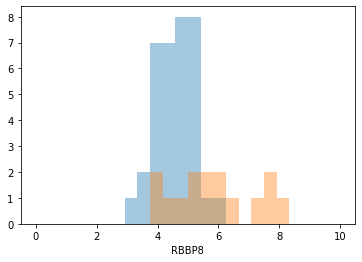

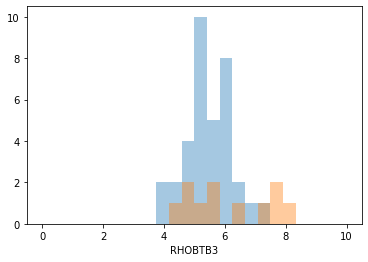

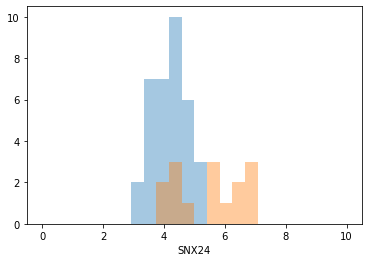

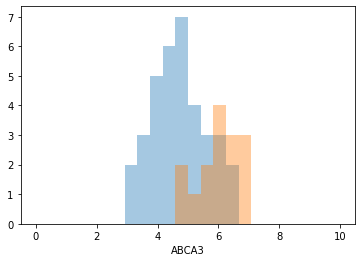

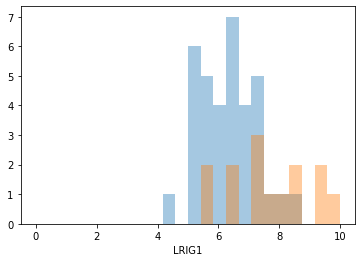

In [ ]:
if TEST:
    in_dir = 'test_input/%s' % date
    out_dir = 'test_output/%s' % date
    if os.path.exists(in_dir):
        shutil.rmtree(in_dir)
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    mkdir_p(in_dir)
    mkdir_p(out_dir)
    _exp = exp.reindex(mapper['HALLMARK_ESTROGEN_RESPONSE_EARLY']).dropna()
    test = {'HALLMARK_ESTROGEN_RESPONSE_EARLY': [x for x in mapper['HALLMARK_ESTROGEN_RESPONSE_EARLY']]}
    
    # Need global parameters
    mu = _exp.mean(axis=1)
    std = _exp.std(axis=1)
    corr = AlmightyCorrcoefEinsumOptimized(_exp.T, _exp.T)
    cov = corr2cov(corr, std.values.reshape(len(std), 1))
    
    print("Starting Run...")
    run_validation(in_dir,
                   out_dir,
                   _exp, 
                   test,
                   [1.5],
                   [0.25],
                   mu, cov, 
                   [50, 100])

In [ ]:
# The real deal
if not TEST:
    in_dir = 'input/%s' % date
    out_dir = 'output/%s' % date
    mkdir_p(in_dir)
    mkdir_p(out_dir)

    with open(os.path.join(out_dir, 'SCALE'), 'a') as f:
        f.write(date)

    # Need global parameters
    mu = exp.mean(axis=1)
    std = exp.std(axis=1)
    corr = AlmightyCorrcoefEinsumOptimized(exp.T, exp.T)
    cov = corr2cov(corr, std.values.reshape(len(std), 1))
    
    gs = {'HALLMARK_FATTY_ACID_METABOLISM': [x for x in mapper['HALLMARK_FATTY_ACID_METABOLISM']]}

    run_validation(in_dir, 
                   out_dir,
                   exp, 
                   gs,
                   [0.75],
                   [0.25],
                   mu, cov,
                   [50, 100, 200, 300, 400, 500, 1000])